###Import libraries 

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from math import ceil
import time
import matplotlib.pyplot as plt
import seaborn as sns
tf.compat.v1.disable_eager_execution()

###Set hyper parameters

In [ ]:
n_hidden_layers = 3
n_neurons_in_hidden_layer = [500, 400, 300]
n_classes = 10
n_batch = 128
n_epoch = 15
regularizer_rate = 0.005
learning_rate = 0.001

###Load data
####Following funtion loads MNIST dataset hosted in Yann LeCun website "http://yann.lecun.com/exdb/mnist/" 

Loading MNIST dataset
Data is successfully loaded


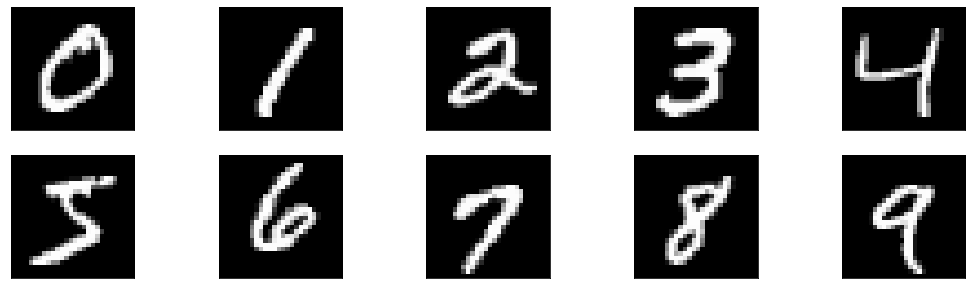

In [ ]:
print('Loading MNIST dataset')
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('Data is successfully loaded')

fig_size = [18, 5]
label_fontsize = 20
fig = plt.figure(figsize=fig_size)
for img_sample in np.arange(10):  
  img_index = np.where(y_train==img_sample)[0][0]
  img = x_train[img_index]
  ax = plt.subplot(2, 5, img_sample+1)
  ax.imshow(img, cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

###Convert y labels (both test and train) to one-hot vectors

In [ ]:
print('Converting y labels of test and train data to one-hot vectors')
y_train_one_hot = tf.one_hot(y_train, n_classes)
y_train_one_hot = y_train_one_hot.eval(session=tf.compat.v1.Session())
y_test_one_hot = tf.one_hot(y_test, n_classes)
y_test_one_hot = y_test_one_hot.eval(session=tf.compat.v1.Session())

Converting y labels of test and train data to one-hot vectors


###Reshape input images to flattened vectors

In [ ]:
print('Reshaping test and train input data to flattened vectors')
x_train_reshape = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
x_test_reshape = x_test.reshape(x_test.shape[0], np.prod(x_test.shape[1:]))

Reshaping test and train input data to flattened vectors


###Brief the network architecture

In [ ]:
n_inp_features = x_train_reshape.shape[-1]
n_neurons_in_network = [n_inp_features]+n_neurons_in_hidden_layer+[n_classes]
tot_layers = n_hidden_layers + 2
n_data_split = ceil(x_train.shape[0]/n_batch)
print('')
print('-----------Network architecture design is as follows:-------------')
print('Total {} layers'.format(tot_layers))
print('Input layer ({} neurons) --> {} hidden layers ({} neurons each) --> output layer ({} neurons)'.format(n_inp_features, n_hidden_layers, n_neurons_in_hidden_layer, n_classes))
print('-------------------------------------------------------------------')
print('')
print('-----------Network training hyper-parameters are as follows:-----------')
print('Number of training epochs = {}'.format(n_epoch))
print('Number of training data per batch = {}'.format(n_batch))
print('Learning rate = {}'.format(learning_rate))
print('Regularization rate = {}'.format(regularizer_rate))
print('-------------------------------------------------------------------')


-----------Network architecture design is as follows:-------------
Total 5 layers
Input layer (784 neurons) --> 3 hidden layers ([500, 400, 300] neurons each) --> output layer (10 neurons)
-------------------------------------------------------------------

-----------Network training hyper-parameters are as follows:-----------
Number of training epochs = 15
Number of training data per batch = 128
Learning rate = 0.001
Regularization rate = 0.005
-------------------------------------------------------------------


###Initialise place holders for data and label

In [ ]:
x = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, n_inp_features])
y = tf.compat.v1.placeholder(dtype=tf.float32)

###Initalize variables for weight matrix

In [ ]:
layer_dict = {}
for layer in range(tot_layers-1):
	layer_dict[layer] = {'weights':tf.Variable(tf.random.normal([n_neurons_in_network[layer], n_neurons_in_network[layer+1]], stddev=1/tf.sqrt(float(n_neurons_in_network[layer]))), dtype=tf.float32, name='weights_{}'.format(layer)), 
						'biases':tf.Variable(tf.random.normal([n_neurons_in_network[layer+1]]), dtype=tf.float32, name='biases_{}'.format(layer))}

###Model the neural network

In [ ]:
def neural_network(data):
	layer_resp_dict = {}
	for layer in range(tot_layers-1):
		layer_now = layer_dict[layer]
		layer_weight = layer_now['weights']
		layer_bias = layer_now['biases']
		if layer == 0:
			layer_resp = tf.add(tf.matmul(data, layer_weight), layer_bias)
			layer_resp_activation = tf.nn.relu(layer_resp)
		else:
			layer_resp = tf.add(tf.matmul(layer_resp_activation, layer_weight), layer_bias)
			if layer != range(tot_layers-1)[-1]:
				layer_resp_activation = tf.nn.relu(layer_resp)
			else:
				layer_resp_activation = tf.nn.softmax(layer_resp)
		layer_resp_dict[layer] = layer_resp_activation
	return layer_resp_dict

###Train the neural network

In [ ]:
def train_neural_network(x):
  start_time = time.time()

  layer_resp_dict = neural_network(x)
  prediction = layer_resp_dict[n_hidden_layers]
  correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))	
  accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
  weight_regularization = 0
  weight_list = []
  bias_list = []
  for layer in range(tot_layers-1):
    layer_now = layer_dict[layer]
    layer_weight = layer_now['weights']
    layer_bias = layer_now['biases']
    weight_regularization = weight_regularization + regularizer_rate*tf.nn.l2_loss(layer_weight)
    weight_list.append(layer_weight)
    bias_list.append(layer_bias)
  optimize_var_list = weight_list + bias_list
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y)) + weight_regularization  
  optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost, var_list=optimize_var_list)


  with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    data_index_arr = np.arange(x_train.shape[0])
    epch_cost_list = []
    epch_accuracy_list = []
    for epoch in range(n_epoch):
      np.random.shuffle(data_index_arr)
      cost_ = 0
      for index_split in np.array_split(data_index_arr, n_data_split):
        x_train_batch = x_train_reshape[index_split]
        y_train_batch = y_train_one_hot[index_split]
        sess.run(optimizer, feed_dict={x:x_train_batch, y:y_train_batch})
        cost_ = cost_ + sess.run(cost, feed_dict={x:x_train_batch, y:y_train_batch})
      epch_cost_list.append(cost_)
      epch_accuracy = sess.run(accuracy, feed_dict={x:x_train_reshape, y:y_train_one_hot})
      epch_accuracy_list.append(epch_accuracy)
      print('Epoch = {}, cost = {}, accuracy = {}'.format(epoch, cost_, epch_accuracy))
		
    print('Accuracy on test dataset = {}'.format(sess.run(accuracy, feed_dict={x:x_test_reshape, y:y_test_one_hot})))  
    
    print('Plotting cost function vs training epoch')
    fig_size = [10, 5]
    label_fontsize = 18
    fig = plt.figure(figsize=fig_size)
    ax = plt.subplot(131)
    epoch_arr = np.arange(n_epoch)
    ax.plot(epoch_arr, epch_cost_list, linewidth=3)
    ax.set_xlabel('Epoch number', fontsize=label_fontsize)
    ax.set_ylabel('Cost function', fontsize=label_fontsize)
    ax.set_title('Cost function vs training epoch', fontsize=label_fontsize)
    ax.set_xticks(epoch_arr)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)     

    print('Plotting accuracy vs training epoch')
    ax = plt.subplot(133)
    epoch_arr = np.arange(n_epoch)
    ax.plot(epoch_arr, epch_accuracy_list, linewidth=3)
    ax.set_xlabel('Epoch number', fontsize=label_fontsize)
    ax.set_ylabel('Accuracy', fontsize=label_fontsize)
    ax.set_title('Accuracy vs training epoch', fontsize=label_fontsize)
    ax.set_xticks(epoch_arr)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show() 

    print('Saving checkpoints...')
    variable_list = []
    for layer in range(tot_layers-1):
      layer_now = layer_dict[layer]
      globals()[f"weight_{layer}"] = layer_now['weights']
      globals()[f"bias_{layer}"] = layer_now['biases']
      variable_list.append(globals()[f"weight_{layer}"])
      variable_list.append(globals()[f"bias_{layer}"])
    saver = tf.compat.v1.train.Saver(variable_list)
    save_path = saver.save(sess, "./saved_variables.ckpt")
    print('Checkpoints are saved')    
    end_time = time.time()
    tot_time = round((end_time-start_time)/60, 2)
    print('Network training is completed in {} minutes'.format(tot_time))


###Run the network

Epoch = 0, cost = 1309.172157049179, accuracy = 0.09893333166837692
Epoch = 1, cost = 860.410330414772, accuracy = 0.8382499814033508
Epoch = 2, cost = 748.6613485813141, accuracy = 0.9463499784469604
Epoch = 3, cost = 733.1162600517273, accuracy = 0.9453833103179932
Epoch = 4, cost = 728.4254183769226, accuracy = 0.9526833295822144
Epoch = 5, cost = 726.1001878976822, accuracy = 0.9526500105857849
Epoch = 6, cost = 725.7507053613663, accuracy = 0.951366662979126
Epoch = 7, cost = 725.098116517067, accuracy = 0.9646000266075134
Epoch = 8, cost = 723.7662597894669, accuracy = 0.9538333415985107
Epoch = 9, cost = 723.1778582334518, accuracy = 0.9642999768257141
Epoch = 10, cost = 722.6840664148331, accuracy = 0.9584166407585144
Epoch = 11, cost = 721.6244212388992, accuracy = 0.9661833047866821
Epoch = 12, cost = 721.2166788578033, accuracy = 0.9666666388511658
Epoch = 13, cost = 721.1374204158783, accuracy = 0.9689833521842957
Epoch = 14, cost = 721.1869947910309, accuracy = 0.967533349

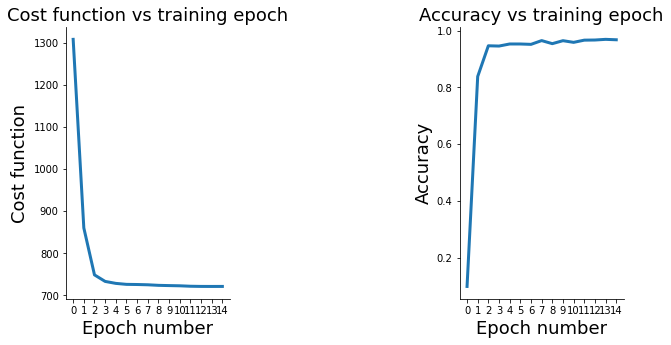

Saving checkpoints...
Checkpoints are saved
Network training is completed in 0.42 minutes


In [ ]:
train_neural_network(x)


###Prediction using the trained network 
####(a) Set the prediction function and load the saved weights

In [ ]:
variable_list = []
for layer in range(tot_layers-1):
  layer_now = layer_dict[layer]
  globals()[f"weight_{layer}"] = layer_now['weights']
  globals()[f"bias_{layer}"] = layer_now['biases']
  variable_list.append(globals()[f"weight_{layer}"])
  variable_list.append(globals()[f"bias_{layer}"])

saver = tf.compat.v1.train.Saver(variable_list)
def classify(image):
  image = image[tf.newaxis, ..., tf.newaxis]
  image_ = tf.image.resize(image, [28, 28])
  image_ = tf.reshape(image_, [28, 28])
  image_ = image_.eval(session=tf.compat.v1.Session())
  image_reshape = image_.reshape(-1, np.prod(image_.shape[0:]))

  layer_resp_dict = neural_network(x)
  prediction = layer_resp_dict[n_hidden_layers]

  with tf.compat.v1.Session() as sess:
      saver.restore(sess, "./saved_variables.ckpt")
      layer_dict = {}
      for layer in range(tot_layers-1):
        layer_dict[layer] = {'weights':globals()[f"weight_{layer}"], 'biases':globals()[f"bias_{layer}"]}

      prediction_ = sess.run(prediction, feed_dict={x:image_reshape})
      prediction_ = prediction_[0]
      return prediction_
      


###Prediction using the trained network 
####(b) Input a test image to the network

INFO:tensorflow:Restoring parameters from ./saved_variables.ckpt


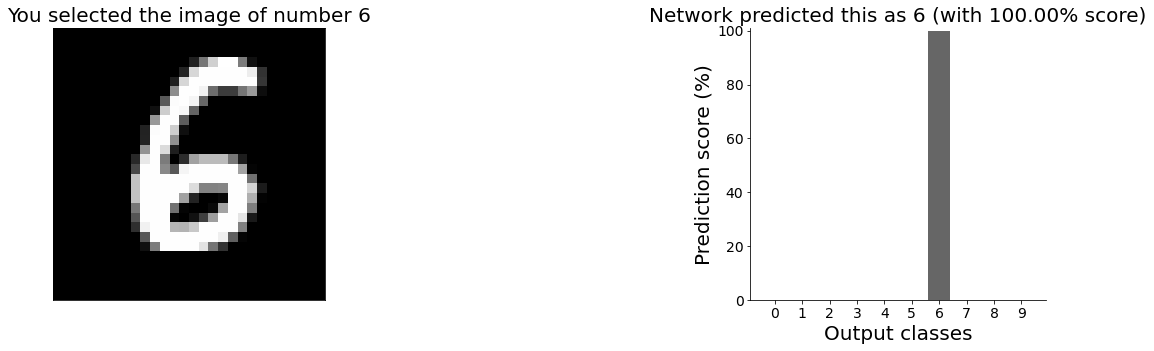

In [ ]:
# There are a total of 10,000 test images. Select any one of them below ranging from 0-9999 
# (For example, give test_image_index = 0, for inputing the first test image)
test_image_index = 3331

# Get the test image
input_class = y_test[test_image_index]
input_image = x_test[test_image_index]
prediction_out = classify(x_test[test_image_index])*100
predicted_max_score = round(prediction_out.max(),2)

# Plot input image
fig_size = [18, 5]
label_fontsize = 20
fig = plt.figure(figsize=fig_size)
ax = plt.subplot(131)
ax.imshow(input_image, cmap='gray')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('You selected the image of number {}'.format(input_class), fontsize=label_fontsize)

# Plot network output
ax = plt.subplot(133)
class_arr = np.arange(n_classes)
ax.bar(class_arr, prediction_out, linewidth=3, color=[0.4,0.4,0.4])
ax.set_xlabel('Output classes', fontsize=label_fontsize)
ax.set_ylabel('Prediction score (%)', fontsize=label_fontsize)
ax.set_title('Network predicted this as {0} (with {1:.2f}% score)'.format(np.argmax(prediction_out), predicted_max_score), fontsize=label_fontsize)
ax.set_xticks(class_arr)
ax.set_ylim(0,101)
ax.tick_params(labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show() 

###Feature vector visualization using t-SNE
####(a) Computing t-SNE embedding vectors

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

layer_resp_dict = neural_network(x)
feature_vector_last_hidden_layer = layer_resp_dict[n_hidden_layers-1]

with tf.compat.v1.Session() as sess:
  start_time = time.time()
  saver.restore(sess, "./saved_variables.ckpt")
  layer_dict = {}
  for layer in range(tot_layers-1):
    layer_dict[layer] = {'weights':globals()[f"weight_{layer}"], 'biases':globals()[f"bias_{layer}"]}
  
  feature_vector_last_hidden_layer_ = sess.run(feature_vector_last_hidden_layer, feed_dict={x:x_test_reshape})
  tsne_results = tsne.fit_transform(feature_vector_last_hidden_layer_)
  end_time = time.time()
  tot_time = round((end_time-start_time)/60, 2)
  print('t-SNE is completed in {} min'.format(tot_time))


INFO:tensorflow:Restoring parameters from ./saved_variables.ckpt
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.359s...
[t-SNE] Computed neighbors for 10000 samples in 9.033s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 3.454122
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.009857
[t-SNE] KL di

###Feature vector visualization using t-SNE
####(b) Plotting t-SNE embedding vectors

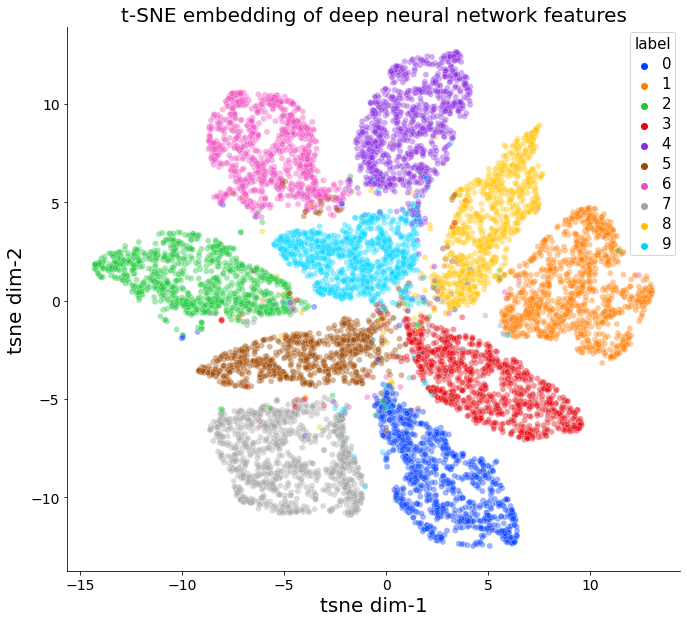

In [ ]:
label_fontsize = 20  
df_subset = pd.DataFrame()
df_subset['tsne dim-1'] = tsne_results[:,0]
df_subset['tsne dim-2'] = tsne_results[:,1]
df_subset['label'] = y_test

plt.figure(figsize=(11,10))
ax = plt.subplot(111)
ax.set_title('t-SNE embedding of deep neural network features', fontsize=label_fontsize)
sns.scatterplot(
    x=df_subset.columns[0], y=df_subset.columns[1],
    hue=df_subset.columns[2],
    palette=sns.color_palette(palette="bright", n_colors=10),
    data=df_subset,
    legend="full",
    alpha=0.4
)
ax.set_xlabel(df_subset.columns[0], fontsize=label_fontsize)
ax.set_ylabel(df_subset.columns[1], fontsize=label_fontsize)
ax.tick_params(labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.setp(ax.get_legend().get_texts(), fontsize='15')
plt.setp(ax.get_legend().get_title(), fontsize='15')
plt.show()